<a id="Title"></a>
# <span style="color:teal;font-weight:bold;">Spaceship Titanic 🏁 Getting familiar</span>

This notebook is my initial step on the <span style="font-style:italic;">Spaceship Titanic</span> competition. Here, I <span style="font-weight:bold;">analyze the Leaderboard scores and experiment with very simple Machine Learning models, using minimally edited data</span>.

The methodology of this work is based on my previous notebook <a href="https://www.kaggle.com/code/fertmeneses/titanic-kaggle-full-analysis">Titanic/Kaggle -Full analysis</a> from the <span style="font-style:italic;">Titanic - Machine Learning from Disaster</span> competition.

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

[**Leaderboard scores**](#LB)

[**Minimally process data**](#Min_data)

  - [Load raw data](#Load)
    
  - [Fill missing values](#Correct)
    
  - [Drop or One-Hot encode columns](#Encode)

[**Try simple ML models**](#ML)

  - [Train and evaluate](#ML_train) 
  
  - [Analyze results](#ML_analyze)
  
[**Conclusions**](#Conclusions)

# <font color='teal'>Leaderboard scores</font> <a class="anchor" id="LB"></a>

What should I expect for my submission scores in this competition? In the following plot, I study the <span style="font-weight:bold;">Public Leaderboard scoring, updated on 2024-08-01</span>, with 2145 submissions.

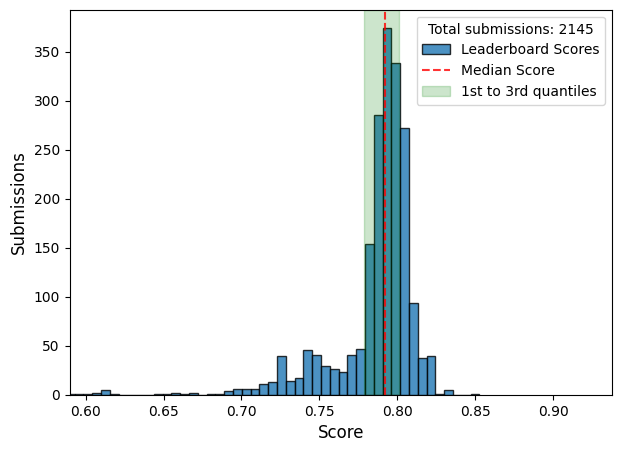

Median score: 0.79191.
75% submissions are below 0.80126.
95% submissions are below 0.810094.
Best score: 0.8527.


In [1]:
import pandas as pd

# Load leaderboard scores:
LB_file = "/kaggle/input/spaceship-titanic-getting-started-fm/spaceship-titanic-publicleaderboard-2024-08-01.csv"
LB_scores = pd.read_csv(LB_file)['Score'] # Scores (fractions from 0 to 1)
# Set reference values and calculate the percentaje of scores between them:
quantile_1, quantile_3 = LB_scores.quantile([0.25,0.75])
median = LB_scores.median()

import matplotlib.pyplot as plt

# Plot scoring histogram with zoomed-in region:
fig, ax = plt.subplots(figsize=(7,5))
hist = LB_scores.hist(bins=151,alpha=0.8,grid=False,edgecolor='black',
                      label='Leaderboard Scores',ax=ax)
ax.axvline(median,ls='--',lw=1.5,color='r',
           label='Median Score',alpha=0.8)
ax.axvspan(quantile_1, quantile_3, alpha=0.2, color='green',
           label='1st to 3rd quantiles')
ax.set_xlabel('Score',fontsize=12), ax.set_ylabel('Submissions',fontsize=12)
ax.set_xlim([LB_scores.mean()-LB_scores.std(),LB_scores.max()*1.1])
plt.legend(title=f'Total submissions: {len(LB_scores)}')
plt.show()
# Print reference values:
print(f'Median score: {median}.')
print(f'75% submissions are below {quantile_3}.')
print(f'95% submissions are below {LB_scores.quantile(0.95)}.')
print(f'Best score: {LB_scores.max()}.')

# <font color='teal'>Minimally process data</font> <a class="anchor" id="Min_data"></a>

I'm not focusing on data edition nor analysis in this notebook, but <span style="font-weight:bold;">I need to do a minimum intervention so ML models can work correctly</span>. These are the steps that I'm doing:

1. Load the data.
2. Fill missing values.
3. Drop non-numeric features with too many unique values ($>$10).
4. One-Hot encode non-numeric features with few unique values ($\leq$ 10).

In the next lines, I import the raw data and summarize the information:

In [2]:
# Load original datasets:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv') # Training dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv') # Testing dataset
# Print some data examples:
train_df.head()
# Get information about datasets:
print('_'*40+'\n\nTRAINING DATASET:\n')
train_df.info()
print('_'*40+'\n\nTESTING DATASET:\n')
test_df.info()

________________________________________

TRAINING DATASET:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
________________________________________

TESTING DATASET:

<class 'pandas.core.f

## <font color='teal'>Fill missing values</font> <a class="anchor" id="Correct"></a>

Missing values will be correct with the following criteria:

* Numeric features: assign mean value.

* Non-numeric features: assign most frequent value.

First, I identify the number of missing values in each feature:

In [3]:
from termcolor import colored

print('-'*5,' Missing values in train/test datasets ','-'*5)
for col in test_df.columns:
    # Count missing values:
    N_train = train_df[col].isna().sum() 
    N_test = test_df[col].isna().sum()
    # Print results:
    color_train = 'red' if N_train else 'green'
    color_test = 'red' if N_test else 'green'
    print(col,':',colored(N_train, color_train),'/',colored(N_test, color_test))

-----  Missing values in train/test datasets  -----
PassengerId : 0 / 0
HomePlanet : 201 / 87
CryoSleep : 217 / 93
Cabin : 199 / 100
Destination : 182 / 92
Age : 179 / 91
VIP : 203 / 93
RoomService : 181 / 82
FoodCourt : 183 / 106
ShoppingMall : 208 / 98
Spa : 183 / 101
VRDeck : 188 / 80
Name : 200 / 94


## <font color='teal'>Drop or One-Hot encode columns</font> <a class="anchor" id="Encode"></a>

Let's first separate numeric from non-numeric columns, and identify the number of unique values for the latter (<span style="font-weight:bold;">PassengerID</span> and <span style="font-weight:bold;">Transported</span> can be ignored):

In [4]:
# Determine column types:
col_numeric = [col for col in test_df.columns if 
               test_df[col].dtypes != 'object']
col_object = [col for col in test_df.columns if col not in col_numeric]
for dataset in [train_df,test_df]:
    # Correct numeric columns:
    for col in col_numeric:
        dataset[col] = dataset[col].fillna(value=dataset[col].mean())
    # Correct non-numeric columns:
    for col in col_object:
        most_freq = dataset[col].value_counts(sort=True).index[0]
        dataset[col] = dataset[col].fillna(value=most_freq)
        
print('-'*10,'Numeric columns:','-'*10)
for col in col_numeric:
    print(f'{col}: {test_df[col].dtypes}')
print('-'*10,'Non-numeric columns:','-'*10)
for col in col_object:
    print(f'{col}: {test_df[col].dtypes}; {test_df[col].nunique()} unique values')

---------- Numeric columns: ----------
Age: float64
RoomService: float64
FoodCourt: float64
ShoppingMall: float64
Spa: float64
VRDeck: float64
---------- Non-numeric columns: ----------
PassengerId: object; 4277 unique values
HomePlanet: object; 3 unique values
CryoSleep: bool; 2 unique values
Cabin: object; 3265 unique values
Destination: object; 3 unique values
VIP: bool; 2 unique values
Name: object; 4176 unique values


/tmp/ipykernel_33/3753414021.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[col] = dataset[col].fillna(value=most_freq)
/tmp/ipykernel_33/3753414021.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[col] = dataset[col].fillna(value=most_freq)
/tmp/ipykernel_33/3753414021.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting',

I keep all numeric features:

* Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck.

I will One-Hot encode the following features:

* HomePlanet, CryoSleep, Destination, VIP.

I will drop the following features:

* Cabin, Name.

In [5]:
# Start encoded datasets:
train_df_enc, test_df_enc = train_df.copy(), test_df.copy()
# OneHot-encode columns:
enc_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
enc_train = pd.get_dummies(train_df_enc[enc_cols])
enc_test = pd.get_dummies(test_df_enc[enc_cols])
train_df_enc = pd.concat([train_df_enc, enc_train], axis=1)
test_df_enc = pd.concat([test_df_enc, enc_test], axis=1)
# Drop columns:
drop_cols = ['Cabin','Name'] + enc_cols
train_df_enc = train_df_enc.drop(drop_cols,axis=1)
test_df_enc = test_df_enc.drop(drop_cols,axis=1)

# <font color='teal'>Try simple ML models</font> <a class="anchor" id="ML"></a>

The goal of this notebook is to get familiar with the submission scores and set benchmarks for future work. Based on the Leaderboard, I'd say that a <span style="font-weight:bold;">0.79 score is the minimum expectation, 0.80 is good but not outstanding, and anything above 0.81 is great</span>.

To complete these observations, I analyze the scores that I can get using very simple ML models and minimally processed data. I work with the following (Supervised) ML models:

* RandomForestClassifier
* LogisticRegression
* GradientBoostingClassifier
* XGBClassifier
* KNeighborsClassifier
* LinearSVC

In this stage, I just play with a few hyperparameters. Whenever possible, I use a fixed initialization seed so results are reproducible. <span style="font-weight:bold;">For each model, I submit to the competition and record both training and submission scores in a .csv file</span>.

## <font color='teal'>Train and evaluate</font> <a class="anchor" id="ML_train"></a>

The following lines contain the training/submission protocols applied to any ML model:

In [6]:
# Define models:
import numpy as np
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

def train_submit_ML(model,train_df,test_df):
    """
    Trains a ML model, and saves the submission file.
    --- Inputs ---
    {model} [Machine Learning model]: ML model to be trained.
    {train_df} [Dataframe]: Training dataset, it must contain the
    columns "PassengerId" and "Transported".
    {test_df} [Dataframe]: Testing dataset, it must contain the
    column "PassengerId".
    --- Outputs ---
    {train_score} [Float]: Training score.
    """
    # Extract PassengerId and Transported columns, if applicable:
    passID_train = train_df['PassengerId']
    passID_test = test_df['PassengerId']
    y_train = train_df['Transported']
    x_train = train_df.drop(['PassengerId','Transported'],axis=1)
    x_test = test_df.drop('PassengerId',axis=1)
    # Initialize model with fixed seed if possible:
    if 'random_state' in dir(model):
        model.random_state = 0 
    # Train the model:
    model.fit(x_train,y_train)
    train_score = model.score(x_train,y_train) # Get training score
    # Make submission:
    preds = model.predict(x_test)
    preds = preds.astype(bool) # Ensure the values are boolean
    df_subm = pd.DataFrame({
        "PassengerId": passID_test,
        "Transported": preds
    }).to_csv('submission.csv', index=False)
    # Final output and message:
    print("Training score:", np.round(train_score,4))
    print("Submission file ready.")
    return train_score, preds

Choose a model and make a submission:

In [7]:
# Options:
# RandomForestClassifier(n_estimators=100, max_depth=5)
# LogisticRegression()
# GradientBoostingClassifier(n_estimators=100, max_depth=3)
# XGBClassifier(n_estimators=100, max_depth=3)
# KNeighborsClassifier(n_neighbors=5)
# LinearSVC(dual=False)

# Define and train simple model:
model = LinearSVC(dual=False)
train_score, preds = train_submit_ML(model,train_df_enc,test_df_enc)

Training score: 0.7837
Submission file ready.


## <font color='teal'>Analyze results</font> <a class="anchor" id="ML_analyze"></a>

Using all collected results from training and submissions, I analyze them using <span style="font-weight:bold;">two evaluation metrics</span>: :

* <span style="font-style:italic;text-decoration:underline">Training score</span>: obtained from a single training session, using the training dataset.

* <span style="font-style:italic;text-decoration:underline">Submission score</span>: obtained from a <span style="font-weight:bold;">Kaggle submission</span> to the  competition, using the testing dataset.

Next, I plot the <span style="font-style:italic;">Training</span> vs. <span style="font-style:italic;">Submission</span> scores results. <span style="font-weight:bold;">The best models are the right-most ones</span>, as they have better <span style="font-style:italic;">Submission</span> scores. A dashed line indicates the ideal training: <span style="font-weight:bold;">points above this line mean there was overfitting, while points below indicate underfitting</span>.

In [8]:
from matplotlib.pyplot import cm

def plot_training_submission_scores(df_results):
    """
    Plots training vs submission scores, grouped by ML models.
    --- Inputs ---
    {df_results} [DataFrame]: Results for all trained models, 
    must include the following columns:
    'Model','train_score','subm_score'.
    """
    # Identify features' subsets and models for the results:
    models = sorted(set(df_results['Model'])) 
    
    # Plot figures:
    markers = ["o","<","s","d","v","p","P","^","*","D",">"]
    colors_models = cm.turbo(np.linspace(0, 1, len(models)))
    fig, ax = plt.subplots(figsize=(8,5))
    for j,model in enumerate(models):
        data = df_results[df_results['Model']==model]
        ax.scatter(data['subm_score'],data['train_score'],marker=markers[(j) % len(markers)],
                    s=70,edgecolor='k',color=colors_models[j],alpha=0.7,label=model)    
    range_subm_score = [min(df_results['subm_score'])*0.99,
                        max(df_results['subm_score'])*1.01]
    # Additional configuration:
    ax.axvspan(quantile_1, quantile_3, alpha=0.1, color='green',
                 label='1st to 3rd quantiles')
    ax.plot(range_subm_score,range_subm_score,'--k')
    ax.set(xlabel="Submission Score",ylabel="Training score")
    ax.legend(title='ML Model',ncol=1)
    fig.tight_layout()
    plt.show()

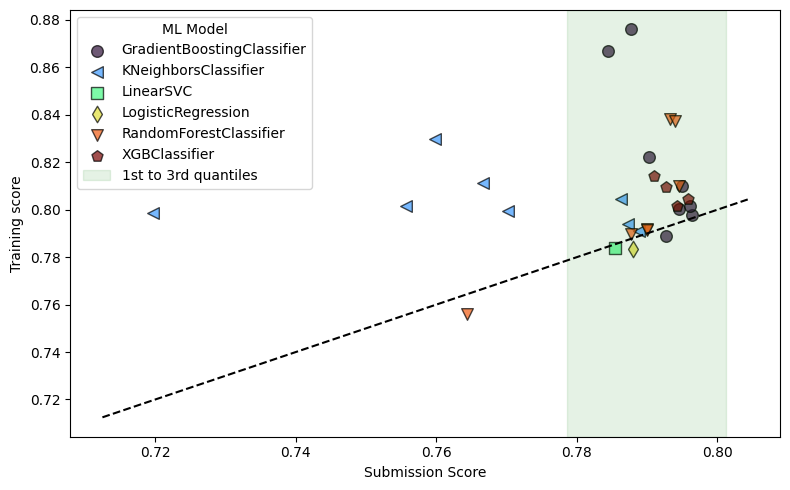

,Model,n_estimators,max_depth,subm_score,train_score
13,GradientBoostingClassifier,100,2,0.79635,0.7978
15,GradientBoostingClassifier,200,2,0.79611,0.8016
18,XGBClassifier,150,2,0.79588,0.8043
11,GradientBoostingClassifier,150,3,0.79494,0.8101
4,RandomForestClassifier,300,7,0.79448,0.8098


In [9]:
# Load pre-trained results:
df_results = pd.read_csv('/kaggle/input/spaceship-titanic-getting-started-fm/Pretrained_Starting.csv')
# Plot training vs submission scores:
plot_training_submission_scores(df_results)
# Display table with 5 best models:
display(df_results[
    ["Model","n_estimators","max_depth","subm_score","train_score"]
].sort_values(["subm_score"],ascending=False).head(5))

For this analysis, I've trained 29 instances of ML models, using different combinations of hyperparameters. A few remarks:

* Most scores are within the "usual" range, which I define as the interval between the 1st and 3rd quartiles. I conclude that <span style="font-weight:bold;">without any further data edition and feature engineering, no significantly better scores are possible</span>.

* Most of the models overfit, specially if they have high values for n_estimators, max_depth or n_neighbors.

* The GradientBoostingClassifier and XGBClassifier top models work much better with very shallow architectures, featuring max_depth=2 and n_estimators $\leq$ 200.



# <font color='teal'>Conclusions</font> <a class="anchor" id="Conclusions"></a>

Mission accomplished! In this notebook, <span style="font-weight:bold;">I minimally corrected the raw data and dropped features with too many unique values. I then trained 6 types of Supervised, Shallow Learning ML models and submitted their results</span>.

A simple analysis shows that, without any further data editing and feature enginnering, submission scores are unlikely to exceed 0.80. To achieve a score higher than 0.80 and be among the best 25% submissions, or even among the top 5% (score > 0.81), then hard work is ahead!

Thank you for taking the time to read this notebook, any comments and feedback are very welcome. I'll start working on my next notebook for this Competition, aiming for the top 5% scores, and will keep you updated!